In [1]:
#!git clone https://github.com/KayoRBC/TCC.git

In [2]:
from reportlab.rl_settings import verbose
!pip install pandas yfinance numpy matplotlib scikit-learn tensorflow requests joblib pytz python-dateutil pmdarima

Defaulting to user installation because normal site-packages is not writeable


In [3]:
import os
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense
import tensorflow as tf
from pandas import DataFrame
import requests
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
import joblib
from datetime import datetime, timedelta
import pytz
from dateutil.relativedelta import relativedelta

from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm
import joblib as jl

from pmdarima import auto_arima
import warnings

2024-10-19 10:53:29.539855: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-19 10:53:29.593962: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-19 10:53:29.651068: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-19 10:53:29.706091: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-19 10:53:29.720668: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-19 10:53:29.808891: I tensorflow/core/platform/cpu_feature_gu

In [4]:
# utils
warnings.filterwarnings("ignore")

def filter_per_date(history: DataFrame, min_date, max_date):
    a = history[(history.index >= min_date) & (history.index <= max_date)]
    return a


def get_first(dict_tickers_history: dict):
    return next(iter(dict_tickers_history.values()))


def show_details(dict_tickers_history: dict):
  print(f"Qtd Tickers: {len(dict_tickers_history.keys())}")
  first = get_first(dict_tickers_history)
  print(f"Fist History size: {len(first)}")
  print(f"Fist Min date: {first.index.min()}")
  print(f"Fist Max date: {first.index.max()}")
  

def plot_arima_results(train_history: DataFrame, test_history: DataFrame, dict_pred: dict):
    # Criando o gráfico
    plt.figure(figsize=(10,6))
    plt.plot(train_history.index, get_prices(train_history), label='Todo treino')
    plt.plot(test_history.index, get_prices(test_history), label='Todo teste')
    
    for periodo, pred in dict_pred.items():
        plt.plot(pred.index, pred.values, label=f'Treino com {periodo}')
    
    # Adicionando rótulos e título
    plt.xlabel('Data')
    plt.ylabel('Valores')
    plt.title('Comparação de predições entre diferentes períodos de treino')
    plt.legend()
    
    # Exibindo o gráfico
    plt.grid(True)
    plt.xticks(rotation=45)  # Rotacionar as datas para melhor visualização
    plt.tight_layout()  # Ajustar espaçamento
    plt.show()

## Seleção das ações

Nesta primeira etapa, iremos pegar as 100 ações da b3 mais negociadas no dia 2023-12-28, ou seja, que possuem o maior "Volume" nesse dia. Além disso, elas precisam ter no mínimo 10 anos de histórico na bolsa.

Para pegar os nomes das ações listadas na B3, fizemos o download de um csv no site https://www.dadosdemercado.com.br/acoes.

In [6]:
def get_b3_ticker_symbols() -> list:
    """
    download do csv nesse link: https://www.dadosdemercado.com.br/acoes
    """
    tickers_df = pd.read_csv('acoes-listadas-b3.csv')
    return tickers_df['Ticker'].tolist()

lst_b3_ticker_symbol = get_b3_ticker_symbols()
print(lst_b3_ticker_symbol)

['LREN3', 'B3SA3', 'HAPV3', 'PETR4', 'ENEV3', 'EMBR3', 'ITUB4', 'AZUL4', 'BBDC4', 'ABEV3', 'ITSA4', 'ASAI3', 'COGN3', 'PETZ3', 'PETR3', 'VALE3', 'BBAS3', 'CPLE6', 'RDOR3', 'CSAN3', 'STBP3', 'MGLU3', 'CMIG4', 'GGBR4', 'IFCM3', 'POMO4', 'CXSE3', 'ELET3', 'RENT3', 'RAIL3', 'WEGE3', 'CMIN3', 'VBBR3', 'CVCB3', 'CCRO3', 'UGPA3', 'TIMS3', 'NTCO3', 'RAIZ4', 'QUAL3', 'EQTL3', 'RADL3', 'JBSS3', 'USIM5', 'FLRY3', 'CSNA3', 'SUZB3', 'CRFB3', 'AMER3', 'RRRP3', 'CPLE3', 'AURE3', 'BBDC3', 'HBSA3', 'DXCO3', 'BEEF3', 'SBSP3', 'PRIO3', 'BBSE3', 'BRFS3', 'ONCO3', 'ALOS3', 'MRVE3', 'PCAR3', 'YDUQ3', 'GOLL4', 'GGPS3', 'VAMO3', 'MLAS3', 'TOTS3', 'AZEV4', 'VVEO3', 'BHIA3', 'HYPE3', 'ECOR3', 'CYRE3', 'GOAU4', 'BRKM5', 'VIVT3', 'VIVA3', 'MULT3', 'LWSA3', 'ALPA4', 'OPCT3', 'AZZA3', 'ANIM3', 'BRAP4', 'MRFG3', 'CPFE3', 'JHSF3', 'SIMH3', 'RANI3', 'MOVI3', 'CLSA3', 'SRNA3', 'CURY3', 'POSI3', 'RAPT4', 'ELET6', 'AESB3', 'EGIE3', 'RECV3', 'MATD3', 'DIRR3', 'GFSA3', 'LJQQ3', 'SMFT3', 'BPAN4', 'SAPR4', 'CBAV3', 'TEND3', 

Agora que temos os nomes das ações, iremos fazer o download de todo o histórico de preço delas com a yfinance.

In [7]:
def somar_um_dia(date: str) -> str:
    data = datetime.strptime(date, "%Y-%m-%d")
    date = data + timedelta(days=1)
    return date.strftime("%Y-%m-%d")


def download_tickers_history(lst_ticker_symbols: list, max_history_date: str) -> dict:
    # precisamos adicionar '.SA' no final de cada ticker pois é assim que o yfinance espera
    df_tickers = yf.download(".SA ".join(lst_ticker_symbols) + ".SA", end=somar_um_dia(max_history_date), group_by="ticker")
    dict_tickers = {}
    for ticker_symbol in set([t[0] for t in df_tickers.keys()]):
        dict_tickers[ticker_symbol] = df_tickers[ticker_symbol].dropna()
    return dict_tickers


dict_tickers_history = None
if (os.path.exists("dict_tickers_history.pkl")):
    dict_tickers_history = jl.load("dict_tickers_history.pkl")
else:
    dict_tickers_history = download_tickers_history(lst_b3_ticker_symbol, max_history_date = "2023-12-28")
    jl.dump(dict_tickers_history, "dict_tickers_history.pkl")

next(iter(dict_tickers_history.values())).head()

Price,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2007-01-26 00:00:00+00:00,1602256.750,1607898.500,1558251.000,1579689.750,1500748.625,67.0
2007-01-29 00:00:00+00:00,1579689.750,1585331.500,1540197.500,1545839.250,1468589.750,33.0
2007-01-30 00:00:00+00:00,1579689.750,1585331.500,1528914.000,1534555.750,1457870.125,33.0
2007-01-31 00:00:00+00:00,1574048.000,1579689.750,1524400.625,1579689.750,1500748.625,4.0
2007-02-01 00:00:00+00:00,1578561.375,1581946.375,1557122.750,1578561.375,1499676.625,6.0


Como podemos ver acima, esses são os dados fornecidos pela yfinance. As informações que nos importam é a data (Date) e o último valor da ação no dia (Close). o Iremos filtrar as ações que possuem no mínimo 10 anos de histórico

In [8]:
max_history_date = "2023-12-28"

def filter_tickers_history_by_age(dict_tickers_history: dict, max_history_date: str, min_age_in_years: int) -> dict:
    dict_tickers = {}
    min_history_date = pytz.utc.localize(datetime.strptime(max_history_date, "%Y-%m-%d")) - relativedelta(years=min_age_in_years)
    for t, history in dict_tickers_history.items():
        if not history.empty and history.index.min() < min_history_date:
            dict_tickers[t] = history
    return dict_tickers

dict_tickers_history = filter_tickers_history_by_age(dict_tickers_history, max_history_date, min_age_in_years=10)

print(f"Quantidade de ações: {len(dict_tickers_history)}")

Quantidade de ações: 289


Agora iremos pegar os 100 com maior volume

In [9]:
def filter_tickers_by_volume(dict_tickers_history: dict, date_filter: str, top: int) -> dict:
    return dict(sorted(dict_tickers_history.items(), key=lambda item: item[1].loc[date_filter, 'Volume'], reverse=True)[:top])

dict_tickers_history = filter_tickers_by_volume(dict_tickers_history, date_filter=max_history_date, top=100)
print(f"Total de tickers: {len(dict_tickers_history)}")
print(f"{'Posição':>3}   {'Ticker Symbol':<13}   {'Volume':>10}")
print("-" * 30)
i = 0    
for ticker, history in dict_tickers_history.items():
    i += 1
    volume = history.loc[max_history_date, "Volume"]
    print(f"{i}   {ticker:<13}   {volume:>10,.2f}")

Total de tickers: 100
Posição   Ticker Symbol       Volume
------------------------------
1   CVCB3.SA        71,001,900.00
2   EMBR3.SA        25,890,400.00
3   ITSA4.SA        23,414,900.00
4   PETR4.SA        21,421,900.00
5   CIEL3.SA        20,929,200.00
6   B3SA3.SA        20,491,200.00
7   VALE3.SA        16,545,800.00
8   ABEV3.SA        16,500,300.00
9   BBDC4.SA        14,852,700.00
10   COGN3.SA        14,615,200.00
11   GFSA3.SA        13,601,100.00
12   MRVE3.SA        13,504,400.00
13   CMIG4.SA        13,371,410.00
14   MGLU3.SA        12,859,371.00
15   ITUB4.SA        12,555,300.00
16   TRPL4.SA        12,457,500.00
17   PETR3.SA        11,746,400.00
18   LREN3.SA        11,687,800.00
19   BBAS3.SA        11,680,800.00
20   POMO4.SA        11,418,400.00
21   CPLE3.SA        11,054,700.00
22   ALPA4.SA        10,988,900.00
23   CPLE6.SA        9,721,200.00
24   ENEV3.SA        9,185,800.00
25   FLRY3.SA        8,182,700.00
26   PRIO3.SA        7,871,200.00
27   USIM5.SA

E por final, iremos limitar em 10 anos os históricos

In [10]:
def cut_tickers_history(dict_tickers_history: dict, max_history_date: str, years_to_intact: int) -> dict:
  data_min = pytz.utc.localize(datetime.strptime(max_history_date, "%Y-%m-%d")) - relativedelta(years=years_to_intact)
  for t, history in dict_tickers_history.items():
    dict_tickers_history[t] = history[history.index > data_min]
  return dict_tickers_history


print("Antes: ")
show_details(dict_tickers_history)
dict_tickers_history = cut_tickers_history(dict_tickers_history, max_history_date, years_to_intact=10)
print("\nDepois: ")
show_details(dict_tickers_history)

Antes: 
Qtd Tickers: 100
Fist History size: 2498
Fist Min date: 2013-12-09 00:00:00+00:00
Fist Max date: 2023-12-28 00:00:00+00:00

Depois: 
Qtd Tickers: 100
Fist History size: 2485
Fist Min date: 2013-12-30 00:00:00+00:00
Fist Max date: 2023-12-28 00:00:00+00:00


Então agora temos a variável 'dict_tickers_history' com as 100 ações mais negociadas do dia 28/12/2024 e com 10 anos histórico de cada uma.

## Predições
Agora que selecionamos as 100 ações, iremos utilizar o LSTM e o ARIMA para predizer os valors



### Separando o que vai ser utilizado de treino e de teste

In [11]:
def split_train_test(dict_tickers_history: dict, train_size: float) -> tuple[dict, dict]:
  train = {}
  test = {}
  for t, h in dict_tickers_history.items():
    limiar = int(len(h) * train_size)
    train[t] = h.iloc[:limiar]
    test[t] = h.iloc[limiar:]
  return train, test

In [12]:
train_history, test_history = split_train_test(dict_tickers_history, train_size = 0.5)
print("Train")
show_details(train_history)
print("-"*30)
print("Test")
show_details(test_history)

Train
Qtd Tickers: 100
Fist History size: 1242
Fist Min date: 2013-12-30 00:00:00+00:00
Fist Max date: 2018-12-26 00:00:00+00:00
------------------------------
Test
Qtd Tickers: 100
Fist History size: 1243
Fist Min date: 2018-12-27 00:00:00+00:00
Fist Max date: 2023-12-28 00:00:00+00:00


In [13]:
def show_history_details(ticker_history: DataFrame):
    print(f"Size: {len(ticker_history)}")
    print(f"Min date: {ticker_history.index.min()}")
    print(f"Max date: {ticker_history.index.max()}")

### Treinando e predizendo valores das ações com ARIMA e LSTM

In [14]:
def separar_train_em_periodos(history) -> dict:
    max_date = history.index.max()
    return {
        "1 mês": filter_per_date(history, min_date=max_date - pd.DateOffset(months=1), max_date=max_date),
        "3 meses": filter_per_date(history, min_date=max_date - pd.DateOffset(months=3), max_date=max_date),
        "6 meses": filter_per_date(history, min_date=max_date - pd.DateOffset(months=6), max_date=max_date),
        "1 ano": filter_per_date(history, min_date=max_date - pd.DateOffset(years=1), max_date=max_date),
        "3 anos": filter_per_date(history, min_date=max_date - pd.DateOffset(years=3), max_date=max_date),
        "5 anos": filter_per_date(history, min_date=max_date - pd.DateOffset(years=5), max_date=max_date)
    }


for periodo, history in separar_train_em_periodos(get_first(train_history)).items():
    print(30 * "-")
    print(periodo)
    show_history_details(history)

------------------------------
1 mês
Size: 21
Min date: 2018-11-26 00:00:00+00:00
Max date: 2018-12-26 00:00:00+00:00
------------------------------
3 meses
Size: 60
Min date: 2018-09-26 00:00:00+00:00
Max date: 2018-12-26 00:00:00+00:00
------------------------------
6 meses
Size: 124
Min date: 2018-06-26 00:00:00+00:00
Max date: 2018-12-26 00:00:00+00:00
------------------------------
1 ano
Size: 248
Min date: 2017-12-26 00:00:00+00:00
Max date: 2018-12-26 00:00:00+00:00
------------------------------
3 anos
Size: 750
Min date: 2015-12-28 00:00:00+00:00
Max date: 2018-12-26 00:00:00+00:00
------------------------------
5 anos
Size: 1242
Min date: 2013-12-30 00:00:00+00:00
Max date: 2018-12-26 00:00:00+00:00


In [15]:
def get_prices(history: DataFrame) -> list:
  return DataFrame(history["Close"]).dropna().values


def create_and_fit_arima(train_history: DataFrame):
    arima_model = auto_arima(get_prices(train_history),
                        start_p=0,
                        start_q=0,
                        d=0,
                        max_p=7,
                        max_q=7,
                        max_d=2,
                        max_order=None, # retira limitacao de p,d,q
                        seasonal=False,
                        trace=True,
                        n_jobs=-1, # paralelizacao
                        error_action='ignore',suppress_warnings=True,
                        stepwise=False # optimizacao
                                     )
    return arima_model.fit(get_prices(train_history))


def predizer_valores_com_arima(train, test):
    arima_model = auto_arima(get_prices(train),
                        start_p=0,
                        start_q=0,
                        d=0,
                        max_p=7,
                        max_q=7,
                        max_d=2,
                        max_order=None, # retira limitacao de p,d,q
                        seasonal=False,
                        trace=False,
                        n_jobs=-1, # paralelizacao
                        error_action='ignore',suppress_warnings=True,
                        stepwise=False # optimizacao
                                     )
    arima_model = arima_model.fit(get_prices(train))
    pred = arima_model.predict(n_periods=len(test))
    return pd.DataFrame({'pred_close': pred}, index=test.index)


def split_into_X_Y_lstm(history: DataFrame, time_step: int):
  X, Y = [], []
  close = DataFrame(history["Close"])
  for i in range(len(history) - time_step):
      a = close.iloc[i:(i + time_step)].values
      X.append(a)
      Y.append(close.iloc[i + time_step].values)  # O valor que queremos prever
  return np.array(X), np.array(Y)


def create_lstm(train, time_step):
    limiar = int(len(train) * 0.5)
    X_train, y_train = split_into_X_Y_lstm(train.iloc[:limiar], time_step)
    X_test, y_test = split_into_X_Y_lstm(train.iloc[limiar:], time_step)
    
    # Cria o modelo
    lstm_model = Sequential()
    lstm_model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
    lstm_model.add(LSTM(50, return_sequences=False))
    lstm_model.add(Dense(25))
    lstm_model.add(Dense(1))
    lstm_model.compile(optimizer='adam', loss='mean_squared_error')
    
    # Treina o modelo
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=0)
    lstm_model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), verbose=0, callbacks=[early_stopping])
    return lstm_model
  
  
def predizer_valores_com_lstm(train, test):
    time_step = int(len(train) * 0.3)
    lstm_model = create_lstm(train, time_step)    
    lst_pred = list()
    X_input = split_into_X_Y_lstm(train, time_step)[0][-1].tolist()
    for _ in range(len(test)):
        pred = lstm_model.predict(np.array([X_input]), verbose=0)
        lst_pred.append(pred[0][0])
        
        # Atualiza X_input para a próxima previsão
        X_input.pop(0)
        X_input.append(pred[0])
    return pd.DataFrame({'pred_close': lst_pred}, index=test.index)


def predizer_valores_acoes(dict_train_history: dict, dict_test_history: dict) -> dict:
    dict_pred_results = None
    if (os.path.exists("dict_pred_results.pkl")):
        dict_pred_results = jl.load("dict_pred_results.pkl")
    else:
        dict_pred_results = dict()
    
    progress = 0
    for ticker_name, train_history in dict_train_history.items():
        test_history = dict_test_history[ticker_name]
        progress += 1
        print(f"Progresso: {progress} - {ticker_name}")
        for periodo, train in separar_train_em_periodos(train_history).items():
            if not dict_pred_results.__contains__(periodo):
                dict_pred_results[periodo] = {"arima": dict(), "lstm": dict()}
            if not dict_pred_results[periodo]["arima"].__contains__(ticker_name):
                dict_pred_results[periodo]["arima"][ticker_name] = predizer_valores_com_arima(train, test_history)
                jl.dump(dict_pred_results, "dict_pred_results.pkl")
            if not dict_pred_results[periodo]["lstm"].__contains__(ticker_name):
                dict_pred_results[periodo]["lstm"][ticker_name] = predizer_valores_com_lstm(train, test_history)
                jl.dump(dict_pred_results, "dict_pred_results.pkl")
    return dict_pred_results

dict_pred_results = predizer_valores_acoes(train_history, test_history)

Progresso: 1 - CVCB3.SA
Progresso: 2 - EMBR3.SA
Progresso: 3 - ITSA4.SA
Progresso: 4 - PETR4.SA
Progresso: 5 - CIEL3.SA
Progresso: 6 - B3SA3.SA
Progresso: 7 - VALE3.SA
Progresso: 8 - ABEV3.SA
Progresso: 9 - BBDC4.SA
Progresso: 10 - COGN3.SA
Progresso: 11 - GFSA3.SA
Progresso: 12 - MRVE3.SA
Progresso: 13 - CMIG4.SA
Progresso: 14 - MGLU3.SA
Progresso: 15 - ITUB4.SA
Progresso: 16 - TRPL4.SA
Progresso: 17 - PETR3.SA
Progresso: 18 - LREN3.SA
Progresso: 19 - BBAS3.SA
Progresso: 20 - POMO4.SA
Progresso: 21 - CPLE3.SA
Progresso: 22 - ALPA4.SA
Progresso: 23 - CPLE6.SA
Progresso: 24 - ENEV3.SA
Progresso: 25 - FLRY3.SA
Progresso: 26 - PRIO3.SA
Progresso: 27 - USIM5.SA
Progresso: 28 - GOLL4.SA
Progresso: 29 - MRFG3.SA
Progresso: 30 - GOAU4.SA
Progresso: 31 - BRFS3.SA
Progresso: 32 - PCAR3.SA
Progresso: 33 - BEEF3.SA
Progresso: 34 - GGBR4.SA
Progresso: 35 - ANIM3.SA
Progresso: 36 - ELET3.SA
Progresso: 37 - UGPA3.SA
Progresso: 38 - CSAN3.SA
Progresso: 39 - BHIA3.SA
Progresso: 40 - RADL3.SA
Progresso

### Analisando resultados

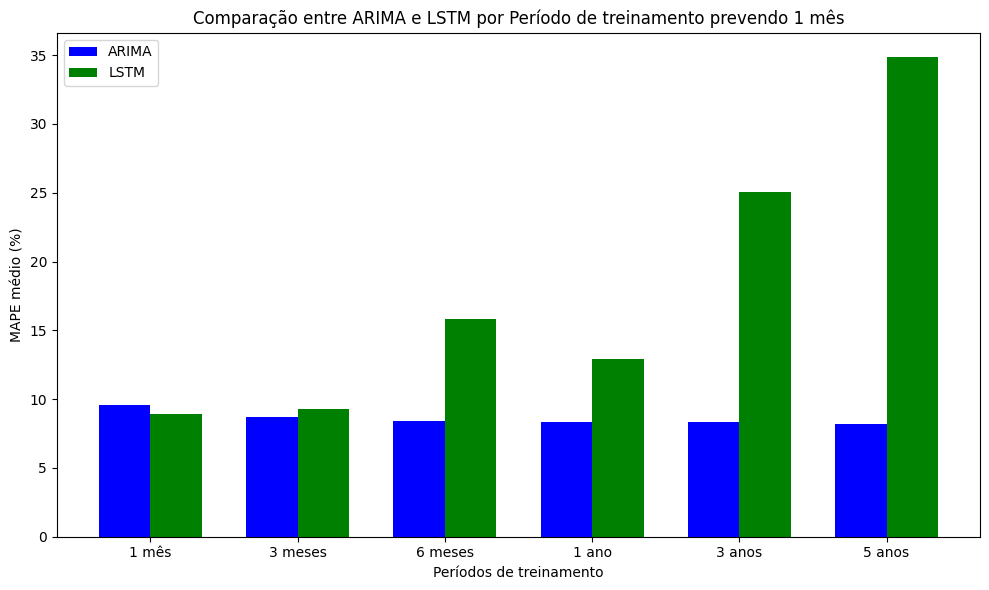

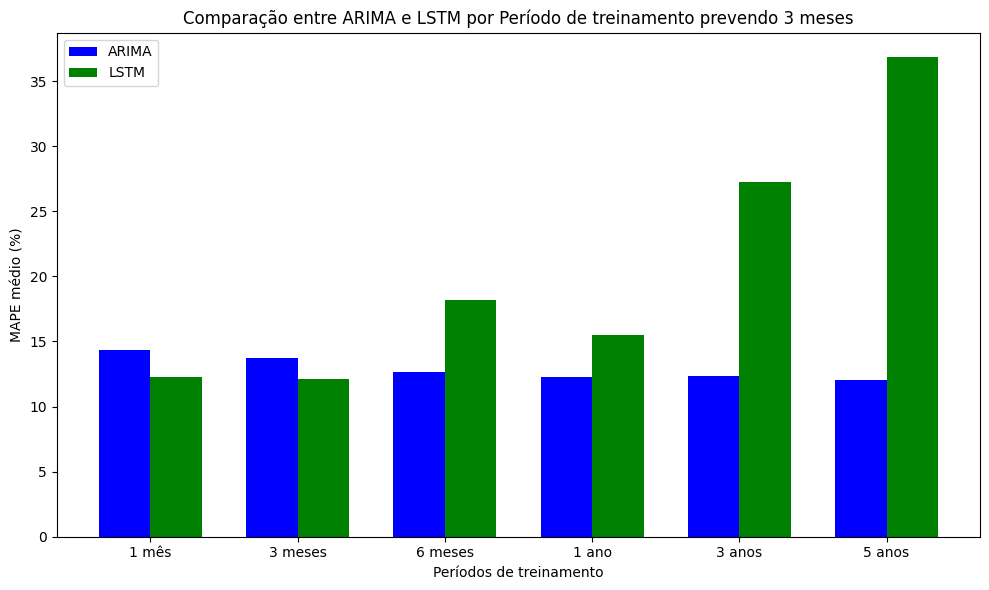

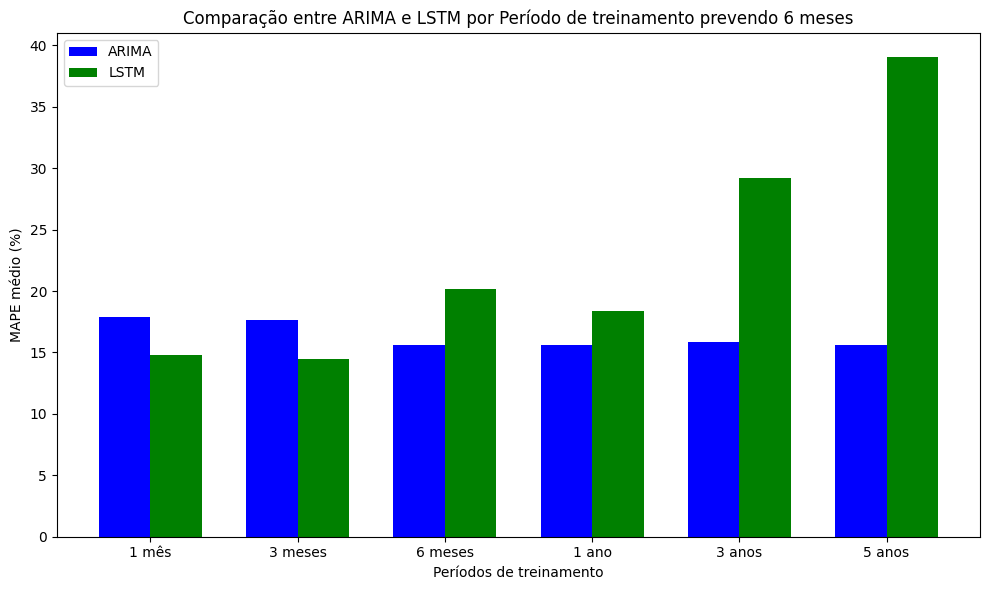

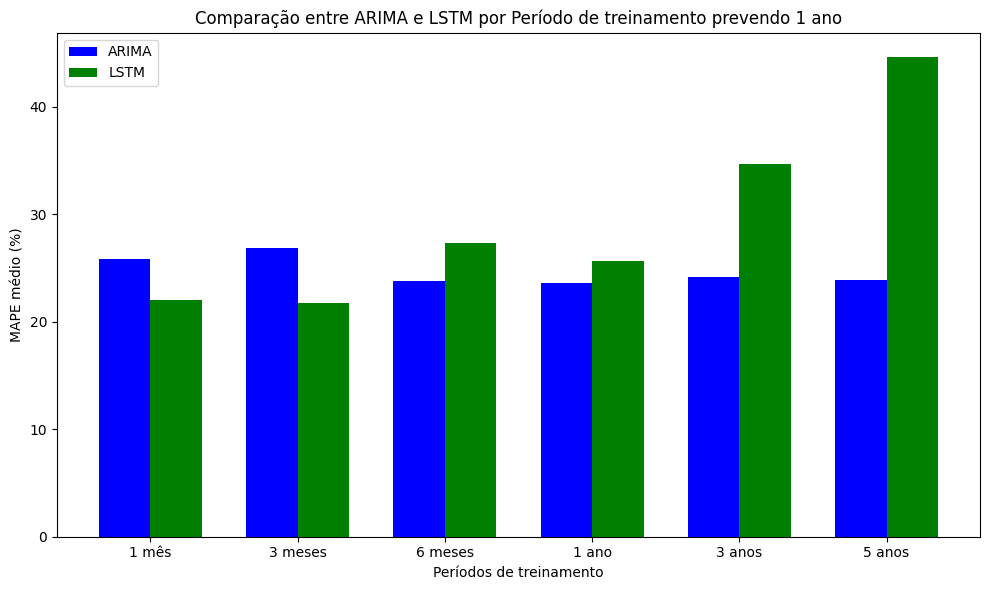

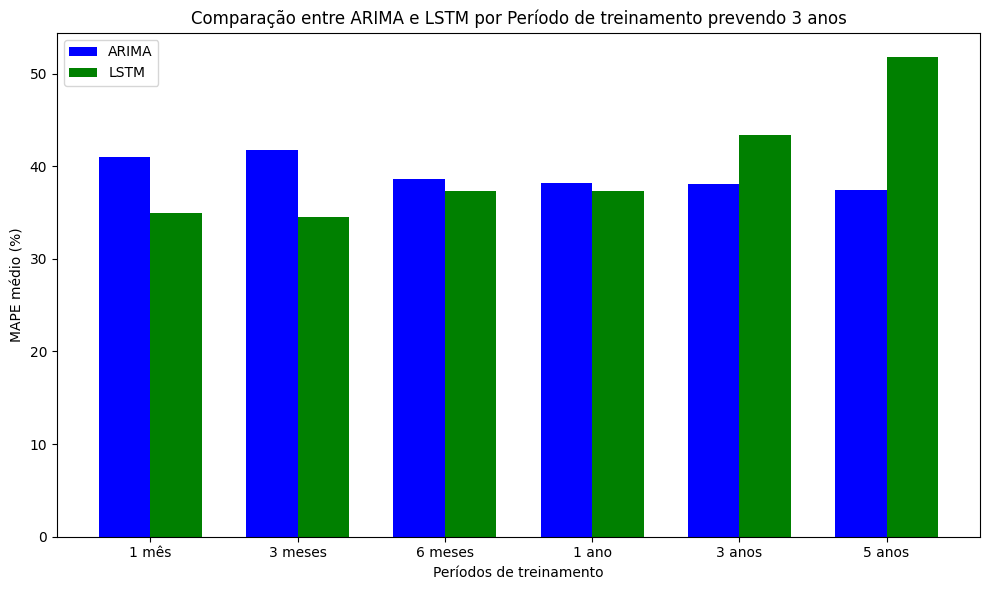

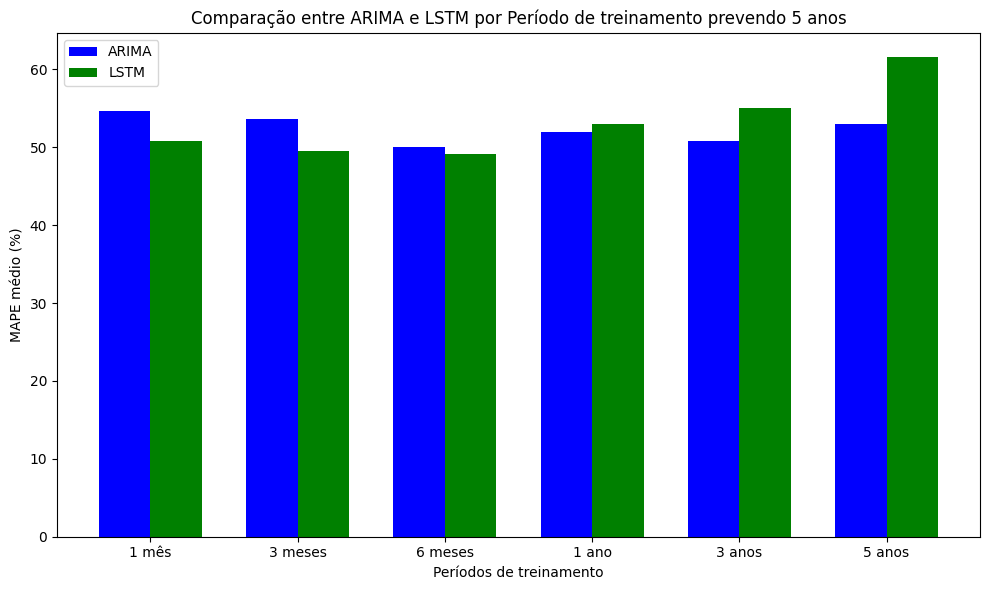

In [16]:
from sklearn.metrics import mean_absolute_percentage_error


def separar_test_em_periodos(history: dict) -> dict:
    h2 = {
        "1 mês": dict(),
        "3 meses": dict(),
        "6 meses": dict(),
        "1 ano": dict(),
        "3 anos": dict(),
        "5 anos": dict()
    }
    for ticker, h in history.items():
        min_date = h.index.min()
        h2["1 mês"][ticker] = filter_per_date(h, min_date, max_date=min_date + pd.DateOffset(months=1))
        h2["3 meses"][ticker] = filter_per_date(h, min_date, max_date=min_date + pd.DateOffset(months=3))
        h2["6 meses"][ticker] = filter_per_date(h, min_date, max_date=min_date + pd.DateOffset(months=6))
        h2["1 ano"][ticker] = filter_per_date(h, min_date, max_date=min_date + pd.DateOffset(years=1))
        h2["3 anos"][ticker] = filter_per_date(h, min_date, max_date=min_date + pd.DateOffset(years=3))
        h2["5 anos"][ticker] = filter_per_date(h, min_date, max_date=min_date + pd.DateOffset(years=5))
    return h2


def calculate_mapes(dict_pred_results, test_history):
    dict_mape = dict()
    for periodo, dict_modelo in dict_pred_results.items():
        for modelo, dict_ticker_name in dict_modelo.items():        
            for ticker_name, y_pred in dict_ticker_name.items():
                if not dict_mape.__contains__(periodo):
                    dict_mape[periodo] = {"arima": dict(), "lstm": dict()}
                h = test_history[ticker_name]
                h = h.loc[h.index.isin(test_history[ticker_name].index)]
                dict_mape[periodo][modelo][ticker_name] = mean_absolute_percentage_error(y_true=get_prices(h), y_pred=y_pred[:len(h)]) * 100
    return dict_mape


def calculate_mape_means(dict_pred_results, test_history):
    dict_mape_means = dict()
    for periodo, dict_modelo in calculate_mapes(dict_pred_results, test_history).items():
        for modelo, dict_ticker_name in dict_modelo.items():        
            sum = 0
            n = 0
            for _, mape in dict_ticker_name.items():
                sum += mape
                n+= 1
            if not dict_mape_means.__contains__(periodo):
                dict_mape_means[periodo] = dict()
            dict_mape_means[periodo][modelo] = float(sum / n) # media dos mapes
    return dict_mape_means


def mostrar_grafico_mapes(dict_pred_results, test_history):
    # Extrair os períodos, os valores do ARIMA e do LSTM
    for periodo, test in separar_test_em_periodos(test_history).items():
        dict_mape_means = calculate_mape_means(dict_pred_results, test)
        periodos = list(dict_mape_means.keys())
        arima_values = [dict_mape_means[periodo]['arima'] for periodo in periodos]
        lstm_values = [dict_mape_means[periodo]['lstm'] for periodo in periodos]
        
        # Configurações do gráfico
        bar_width = 0.35
        index = np.arange(len(periodos))
        
        fig, ax = plt.subplots(figsize=(10, 6))
        
        # Criar as barras
        ax.bar(index, arima_values, bar_width, label='ARIMA', color='b')
        ax.bar(index + bar_width, lstm_values, bar_width, label='LSTM', color='g')
        
        # Título e labels
        ax.set_xlabel('Períodos de treinamento')
        ax.set_ylabel('MAPE médio (%)')
        ax.set_title(f'Comparação entre ARIMA e LSTM por Período de treinamento prevendo {periodo}')
        ax.set_xticks(index + bar_width / 2)
        ax.set_xticklabels(periodos)
        ax.legend()
        
        # Exibir o gráfico
        plt.tight_layout()
        plt.show()
        
mostrar_grafico_mapes(dict_pred_results, test_history)